In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import logging
import warnings
import pymc3 as pm

from epimodel.pymc3_models.cm_effect.models import CMConfirmedAndDeaths, BaseCMModel
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

import numpy as np

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)
warnings.simplefilter(action='ignore', category=FutureWarning)

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Gatherings limited to 10                   0.000 ... 0.130 ... 1.000 ... [0. 1.]
 2 Gatherings limited to 100                  0.000 ... 0.230 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 1000                 0.000 ... 0.258 ... 1.000 ... [0. 1.]
 4 Business suspended - some                  0.000 ... 0.251 ... 1.000 ... [0. 1.]
 5 Business suspended - many                  0.000 ... 0.184 ... 1.000 ... [0. 1.]
 6 Schools and universities closed            0.000 ... 0.328 ... 1.000 ... [0. 1.]
 7 General curfew                             0.000 ... 0.132 ... 1.000 ... [0. 1.]
 8 Healthcare specialisation                  0.000 ... 0.050 ... 1.

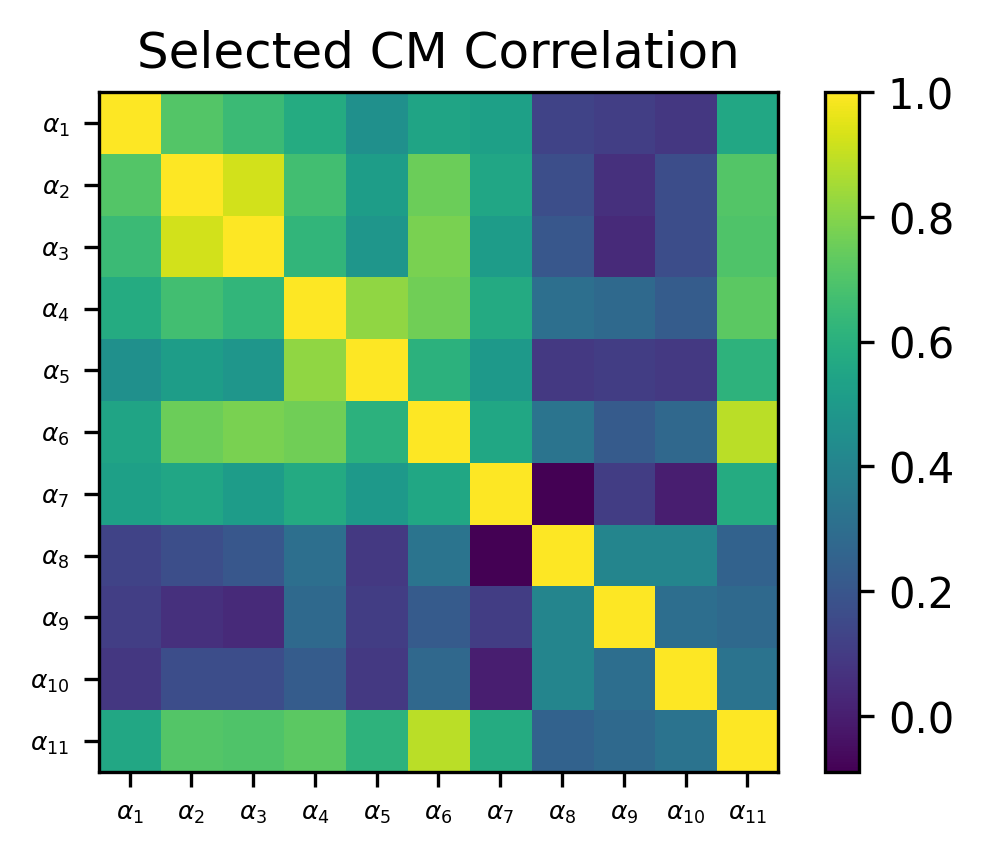

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 37 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MA', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK', 'ZA']


TypeError: cannot unpack non-iterable PreprocessedData object

In [12]:
dp = DataPreprocessor()

data_base_path = "../../data"
countries = ['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 
             'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 
             'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 
             'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK', 'MY',
             'ZA','MA']
cms01_cols = ['Gatherings limited to 10',
              'Gatherings limited to 100',
              'Gatherings limited to 1000',
              'Business suspended - some',
              'Business suspended - many',
              'Schools and universities closed',
              'General curfew',
              'Healthcare specialisation',
              'Mask wearing over 70%',
              'General social distancing',
              'After March 17']

dataset_size, ActiveCMS, Active, Confirmed = dp.preprocess_data(data_base_path, countries, cms01_cols)

In [4]:
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])

# Masking early observations (they depend on unknown pre-existing CMs)
CMDelayCut = 10

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

CMModel = CountermeasureModelV2(dataset_size, ActiveCMS, DelayProb, CMDelayCut, Confirmed, name="CMV2")

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in CMV2_Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.countermeasure_models:Checking Model Test Point
CMV2_BaseGrowthRate_log__          -1.61
CMV2_InitialSize_log__            -70.87
CMV2_CountryGrowthRate_log__        6.27
CMV2_CountryScaleMult_log__       -20.22
CMV2_CMReduction_log__              9.69
CMV2_DailyGrowth_log__           1400.25
CMV2_Observed_missing               0.00
CMV2_Observed                  -15098.43
Name: Log-probability of test_point, dtype: float64



Let's inspect the model more:

In [ ]:
CMModel

In [ ]:
CMModel.sample(100, chains=2, cores=2, init='adapt_diag')

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [CMV2_Observed_missing, CMV2_DailyGrowth, CMV2_CMReduction, CMV2_CountryScaleMult, CMV2_CountryGrowthRate, CMV2_InitialSize, CMV2_BaseGrowthRate]
INFO:pymc3:NUTS: [CMV2_Observed_missing, CMV2_DailyGrowth, CMV2_CMReduction, CMV2_CountryScaleMult, CMV2_CountryGrowthRate, CMV2_InitialSize, CMV2_BaseGrowthRate]
Sampling 2 chains, 0 divergences:  92%|█████████▏| 1098/1200 [02:22<00:12,  7.93draws/s]

In [ ]:
CMModel.plot_inferred_cm_effect()